In [190]:
## Basic Packages

from math import sqrt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Widget packages

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

## Sklearn packages

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

## Spotipy packages (Spotify API)

import spotipy.oauth2
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import spotipy.util
import spotipy

## Importing Bokeh to explore outliers

from bokeh.plotting import figure, output_file, show
import bokeh.models as bmo
from bokeh.palettes import d3
from bokeh.models import Legend, BoxSelectTool, BoxZoomTool, LassoSelectTool
import bokeh.plotting as bpl

## Notebook display settings
pd.options.display.max_columns = 999

In [3]:
## Audio feature descriptions

#https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [4]:
## Read in data

combined_df = pd.read_csv('data/combined_df.csv')

In [5]:
## Trimming down the audio features that I want to explore initially

features_df = combined_df[['release_date', 'album_name', 'name', 'acousticness', 'danceability', 'energy', 
    'loudness', 'key', 'mode', 'tempo', 'valence']]

In [6]:
## Removing duplicate and greatest hits album

album_drop = ["""1 (Remastered)""", """Sgt. Pepper's Lonely Hearts Club Band (Deluxe Edition)""", """Live At The Hollywood Bowl"""]

features_df = features_df[~features_df['album_name'].isin(album_drop)]

In [7]:
## Separating the release date into year, month, day columns

features_df['year'], features_df['month'], features_df['day'] = features_df['release_date'].str.split('-',2).str

## Sort oldest album to newest album

features_df = features_df.sort_values(by = ['year', 'month', 'day'])

## Reset index and assign unique release dates to a list that will be used in the next loop

features_df.reset_index(drop = True, inplace = True)

unique_release = list(features_df.release_date.unique())

In [8]:
## For loop that assigns an album number based on the release date for future plotting

album_number = []

count = 0
record_number = 1

for row in range(len(features_df)):
    if features_df.release_date.iloc[row] == unique_release[count]:
        #print(features_df.release_date.iloc[row], "-------->", unique_release[count], "------->", features_df.release_date.iloc[row] == unique_release[count])
        album_number.append(record_number)
    else:
        #print('Change Album')
        record_number += 1
        count += 1
        album_number.append(record_number)

In [9]:
## Converting resulting list into a dataframe to concat, then renaming the column to show album_number

album_number = pd.DataFrame(album_number)

features_df = pd.concat([features_df, album_number], axis = 1)

features_df.rename(columns = {0 : 'album_number', 'name' : 'song_name'}, inplace = True)

## Creating raw dataframe for linear regression - song recommender

In [10]:
## Importing additional features from audio analysis

audio_analysis = pd.read_csv('data//audio_analysis.csv')
audio_analysis.drop(columns = ['Unnamed: 0'], inplace = True)

## Joining audio features with audio analysis

features_df_2 = features_df.merge(audio_analysis, how = 'left', on = 'song_name')

In [11]:
## Reading in song_composer details

song_composer = pd.read_csv('data/song_artist.csv')

song_composer = song_composer.iloc[:,-5:]

raw_features_df = features_df_2.merge(song_composer, how = 'left', on = 'song_name')

raw_features_df = raw_features_df[raw_features_df.duplicated(subset = 'song_name', keep = 'first') == False]

raw_features_df.reset_index(drop = True, inplace = True)

raw_features_df.rename(columns = {'album_name_x': 'album_name'}, inplace = True)

raw_features_df.drop(columns = ['album_name_y'], inplace = True)

In [12]:
raw_df_columns = list(raw_features_df.columns.values)

In [13]:
## Rearranging columns

raw_features_df = raw_features_df[[ 'release_date',
                                    'album_number',
                                    'album_name',
                                    'track_number',
                                    'song_name',
                                    'year',
                                    'month',
                                    'day',
                                    'acousticness',
                                    'danceability',
                                    'energy',
                                    'loudness',
                                    'valence',
                                    'song_length_seconds']]

In [14]:
## Reshaping dataframe to a long format

raw_feature_melt = pd.melt(raw_features_df, 
                           id_vars = ['release_date',
                                    'album_number',
                                    'album_name',
                                    'track_number',
                                    'song_name',
                                    'year',
                                    'month',
                                    'day'], 
                           var_name = 'feature', value_name = 'value')


In [15]:
## Function that takes a dataframe and iterates through columns to calculate predicted value

def future_value(df, req_feat):
    ## Will iterate through columns to calculate future value
    requested_df = df[df.feature == req_feat]

    x_reg = np.array(requested_df.album_number)
    y_reg = np.array(requested_df.value)

    fit = np.polyfit(x_reg, y_reg, 1)
    fit_fn = np.poly1d(fit) 

    ## Fit the linear regression model to the expected 14th value
    return fit_fn(14)

In [16]:
## Creating a key:value dictionary pair from the unique features
## This will be used by spotify to recommend similar songs to our predicted values

keys = []
values = []

unique_feat_list = list(raw_feature_melt.feature.unique())

for i in unique_feat_list:
    keys.append(i)
    values.append(future_value(raw_feature_melt, i))

pred_dicts = dict(zip(keys, values))

In [17]:
## Spotify asks for the recommended song length in ms

pred_dicts['song_length_seconds'] = round(pred_dicts['song_length_seconds']*1000)

In [18]:
## Display predicted values

pred_dicts

{'acousticness': 0.3062481815012573,
 'danceability': 0.46959219997513746,
 'energy': 0.42664557767342637,
 'loudness': -11.716340633032715,
 'song_length_seconds': 193251.0,
 'valence': 0.415381415240746}

## Find recommendations based on predicted values from linear regression

In [61]:
token_info = sp_oauth.refresh_access_token(token_info['refresh_token'])
token = token_info['access_token']
sp = spotipy.Spotify(auth=token)

NameError: name 'sp_oauth' is not defined

In [58]:
## Uses the artist seed and predicted values to return songs that are similiar

results = sp.recommendations(seed_artists = ['3WrFJ7ztbogyGnTHbHJFl2'], limit = 10,
                                     target_acousticness = pred_dicts['acousticness'],
                                     target_danceability = pred_dicts['danceability'],
                                     target_energy = pred_dicts['energy'],
                                     target_loudness = pred_dicts['loudness'],
                                     target_target_duration_ms = pred_dicts['song_length_seconds'],
                                     target_valence = pred_dicts['valence'])

NameError: name 'sp' is not defined

In [54]:
## Unpack values and create a dataframe

results = results['tracks']

recommend_df = pd.DataFrame(results)

NameError: name 'results' is not defined

In [55]:
## Taking the track ID for additional analysis, plus the song popularity to incorporate popular areas to move into

recommended_tracks = []
popularity = []

for i in range(len(recommend_df)):
    recommended_tracks.append(recommend_df.uri[i])
    popularity.append(recommend_df.popularity[i])

NameError: name 'recommend_df' is not defined

In [ ]:
## Function that utilizes Spotify's audio_features method to return audio features (energy, tempo, speechiness, etc)

def audio_features(song_list):
        results = sp.audio_features(tracks = song_list)
        track_df = pd.DataFrame(results)
        return track_df

In [20]:
## Call function and store dataframe

recommend_audio_feat = audio_features(recommended_tracks)

NameError: name 'audio_features' is not defined

In [21]:
## Function that utilized Spotify's audio_track_analysis method to return track analysis

def audio_track_analysis(song_list):
    audio_feat_list = []
    for i in range(len(song_list)):
        results = sp.audio_analysis(song_list[i])
        audio_feat_list.append(results)
    track_df = pd.DataFrame(audio_feat_list)
    return track_df

In [22]:
## Call function and store dataframe

recommend_track_analysis = audio_track_analysis(recommended_tracks)

NameError: name 'recommended_tracks' is not defined

## Looking at the distribution of the audio features per album

In [23]:
## Reducing features

audio_feat_dist = features_df[['album_name', 'acousticness', 'danceability', 'energy', 'loudness']]

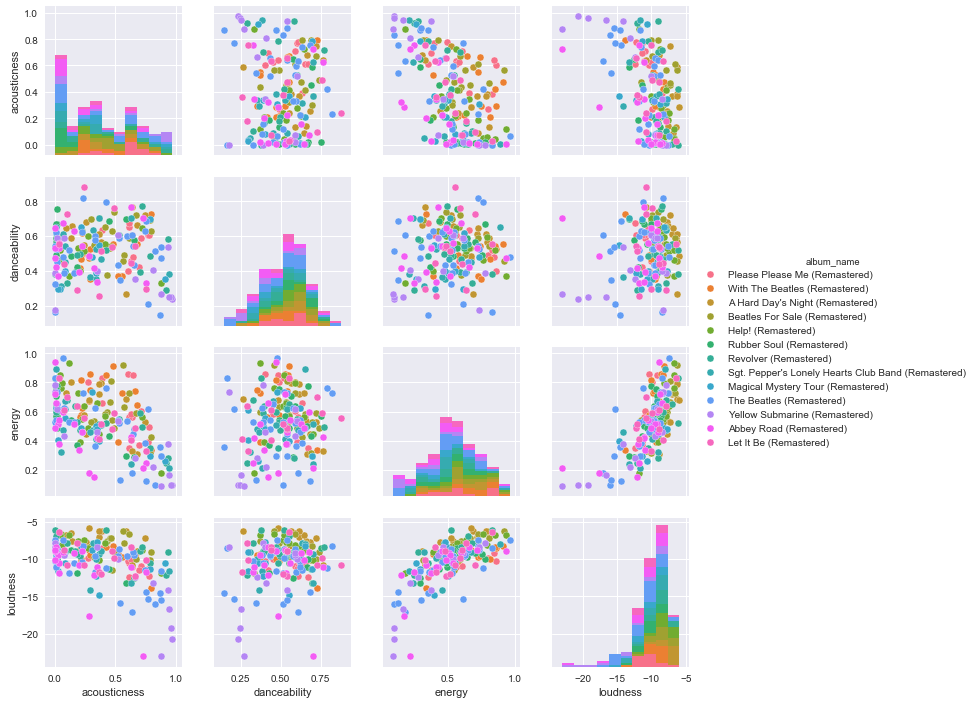

In [24]:
sns.set(rc={'figure.figsize':(12,12)})

_ = sns.pairplot(audio_feat_dist, hue = 'album_name')

## Regression plot of individual audio features

In [25]:
## Selecting features that I want to normalize

reg_features = features_df[['album_number', 
                            'song_name', 
                            'acousticness', 
                            'danceability', 
                            'energy', 
                            'loudness']]

## Importing additional features from audio analysis

audio_analysis = pd.read_csv('data//audio_analysis.csv')
audio_analysis.drop(columns = ['Unnamed: 0'], inplace = True)

## Joining audio features with audio analysis

reg_features = reg_features.merge(audio_analysis, how = 'left', on = 'song_name')

In [26]:
## Reading in song_composer details

song_composer = pd.read_csv('data/song_artist.csv')

song_composer = song_composer.iloc[:,-5:]

reg_features = reg_features.merge(song_composer, how = 'left', on = 'song_name')

reg_features = reg_features[reg_features.duplicated(subset = 'song_name', keep = 'first') == False]

reg_features.reset_index(drop = True, inplace = True)

In [27]:
#reg_features.to_csv('non-normalized_data.csv', index = False)

In [28]:
## Function to normalize features

def feature_norm(df, col):
    return(df[col] - df[col].min())/(df[col].max() - df[col].min())

In [29]:
feature_col_names = ['acousticness',
                     'danceability',
                     'energy',
                     'loudness',
                     'bars_count',
                     'beats_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']

In [30]:
## Iterating through columns to normalize the data 

for i in feature_col_names:
    reg_features[i] = feature_norm(reg_features, i)
    
#reg_features.to_csv('data/normalized_audio_data.csv')

In [31]:
reg_features = pd.read_csv('data/normalized_audio_data.csv')

In [32]:
## Subsetting the data to average and visualize

normalized_features = reg_features[['album_number',
                                    'album_name',
                                     'acousticness',
                                     'danceability',
                                     'energy',
                                     'bars_count',
                                     'sections_count',
                                     'segments_count',
                                     'tatums_count',
                                     'song_length_seconds',
                                     'bpm',
                                     'McCartney',
                                     'Lennon',
                                     'Harrison',
                                     'Other']]

In [33]:
## Use pd.melt to create a lm plot for the features and values

normalized_features = pd.melt(normalized_features, id_vars = ['album_number', 'album_name'], var_name = 'feature', value_name = 'value')

## Making sure that the values are floats

normalized_features['value'] = normalized_features['value'].astype(float)

## Calculating the mean of each feature per album

album_means = normalized_features.groupby(['feature', 'album_number']).mean().reset_index().unstack(['feature'])

In [34]:
album_name_list = reg_features[reg_features.duplicated(subset = ['album_number', 'album_name'], keep = 'first') == False]

album_name_list = album_name_list[['album_number', 'album_name']]

In [35]:
## Creating a dataframe with averages for plotting purposes

norm_feats = normalized_features.groupby(['feature', 'album_number'])['value'].aggregate('mean').unstack(['feature'])

norm_feats['feat_means'] = 'feat_means'

norm_feats.reset_index(drop = False, inplace = True)

norm_feats.rename(columns = {'feature' : 'album_number'}, inplace = True)

norm_feats = pd.merge(norm_feats, album_name_list, how = 'left', on = 'album_number')

norm_feats = norm_feats[norm_feats.duplicated(subset = 'album_name', keep = 'last') == False]

norm_feats.reset_index(drop = True, inplace = True)

reg_features.columns.values

array(['Unnamed: 0', 'album_number', 'song_name', 'acousticness',
       'danceability', 'energy', 'loudness', 'track_number', 'album_name',
       'bars_count', 'beats_count', 'sections_count', 'segments_count',
       'tatums_count', 'song_length_seconds', 'bpm', 'McCartney',
       'Lennon', 'Harrison', 'Other'], dtype=object)

## Individual artist plots

In [36]:
## Function that filters a dataframe based on artist and returns a datframe to be normalized

def solo_data (author):
    solo_df = reg_features[reg_features[author] == 1]
    solo_df = solo_df[['album_number', 'acousticness', 'danceability',
       'energy', 'loudness', 'album_name', 'bars_count',
       'beats_count', 'sections_count', 'segments_count', 'tatums_count',
       'song_length_seconds', 'bpm', author]]
    normalized_features = pd.melt(solo_df, id_vars = ['album_number', 'album_name'], var_name = 'feature', value_name = 'value')

    return normalized_features

In [37]:
## Create individual dataframes for each artist

paul_df = solo_data('McCartney')
john_df = solo_data('Lennon')
george_df = solo_data('Harrison')
othher_df = solo_data('Other')

In [38]:
## Function to create individual dataframes for each artist - used with widgets

def cat_plot(df, x):
    if df == 'paul_df':
        df = paul_df
    elif df == 'john_df':
        df = john_df
    elif df == 'george_df':
        df = george_df
    else:
        df = other_df
    
    temp_df = df[df.feature == x]

    sns.lmplot(x="album_number", y="value", hue="feature", data = temp_df)

In [39]:
## Choosing category from a dropdown

cat_drop = widgets.Dropdown(
    options=['acousticness', 'danceability', 'energy', 'loudness', 'bars_count',
       'beats_count', 'sections_count', 'segments_count', 'tatums_count',
       'song_length_seconds', 'bpm'
        ],
    description='Category:',
    disabled=False,
    readout=True,
)


## Choosing dataframe for a radio selection

df_button = widgets.RadioButtons(
    options=['paul_df', 'john_df', 'george_df', 'other_df'],
    value= 'paul_df',
    description='Choose dataframe:',
    disabled=False
)

In [40]:
widgets.interact(cat_plot, x= cat_drop, df = df_button);

interactive(children=(RadioButtons(description='Choose dataframe:', options=('paul_df', 'john_df', 'george_df', 'other_df'), value='paul_df'), Dropdown(description='Category:', options=('acousticness', 'danceability', 'energy', 'loudness', 'bars_count', 'beats_count', 'sections_count', 'segments_count', 'tatums_count', 'song_length_seconds', 'bpm'), value='acousticness'), Output()), _dom_classes=('widget-interact',))

## Predicting future values for new songs (based on individual artist)

In [41]:
def future_value(df, req_feat):
    ## Takes the requested feature and calculates the regression line, then plots the regression line
    requested_df = df[df.feature == req_feat]

    x = np.array(requested_df.album_number)
    y = np.array(requested_df.value)

    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit) 

    print(fit_fn(14))

In [42]:
## Prints features and predicted values for each artist - may incorporate later

for j in (paul_df, john_df, george_df, other_df):
    unique_feat_list = j.feature.unique()
    for i in unique_feat_list:
        future_value(j, i)
        print("^ - ", i)

NameError: name 'other_df' is not defined

## Correlation Matrix

In [62]:
## Creating an album list for labeling
# reg_features = pd.read_csv('data/normalized_audio_data.csv')


album_list = list(features_df.album_name.unique())

# corr_df = reg_features[[
#              'acousticness',
#              'danceability',
#              'energy',
#              'bars_count',
#              'sections_count',
#              'segments_count',
#              'tatums_count',
#              'song_length_seconds',
#              'bpm',
#              'McCartney',
#              'Lennon',
#              'Harrison',
#              'Other']]

# corr = corr_df.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

## PCA Analysis using sklearn

In [63]:
reg_features = reg_features.append(norm_feats)

In [64]:
## Creating album centroids for each album

reg_features['feat_means'] = reg_features.feat_means.fillna('ind_feat')
reg_features['song_name'] = reg_features.song_name.fillna('Album Center!')
reg_features.reset_index(drop = True, inplace = True)

In [65]:
## Reducing features

pca_df = reg_features[['album_number',
                     'acousticness',
                     'danceability',
                     'energy',
                     'bars_count',
                     'sections_count',
                     'segments_count',
                     'tatums_count',
                     'song_length_seconds',
                     'bpm']]

## Splitting data into target and features

y = pca_df['album_number']
X_norm = pca_df.iloc[:,1:]

## Requesting to use n_compenents that accounts for 95% of variance and applying fit_transform to the model

pca = sklearnPCA(n_components = .95)
transformed = pd.DataFrame(pca.fit_transform(X_norm))

## Print statements to show the impact of each feature

print(pca.explained_variance_)

print(pd.DataFrame(pca.components_,columns=X_norm.columns))

[0.11117688 0.08650604 0.03565914 0.02448829 0.02241448]
   acousticness  danceability    energy  bars_count  sections_count  \
0     -0.737623     -0.124107  0.413627    0.270630        0.153194   
1      0.428668     -0.374412 -0.299602    0.423974        0.293540   
2     -0.304584     -0.057405 -0.460812   -0.056975        0.227452   
3      0.258929      0.790520  0.272641    0.112898        0.225943   
4      0.334029     -0.461294  0.665882   -0.126942        0.054782   

   segments_count  tatums_count  song_length_seconds       bpm  
0        0.191214      0.260335             0.171760  0.197166  
1        0.217215      0.374255             0.264745  0.251075  
2        0.217217     -0.028172             0.271639 -0.717524  
3        0.267925      0.170990             0.231565 -0.123536  
4        0.130765     -0.088305             0.116698 -0.417855  


In [66]:
## Seperating Data into different variables

transformed_original = transformed.iloc[:original_features_len, :]
transformed_original.reset_index(drop = True, inplace = True)

transformed_mean = transformed.iloc[original_features_len:, :]
transformed_mean.reset_index(drop = True, inplace = True)

NameError: name 'original_features_len' is not defined

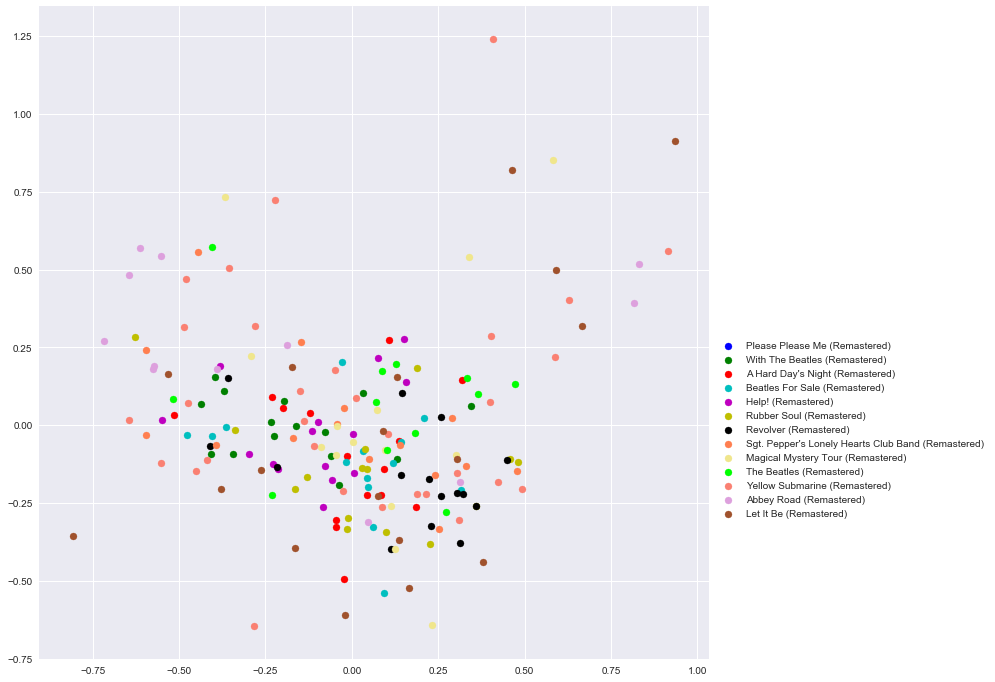

In [67]:
## Plotting results of PCA transformation
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'coral', 'khaki', 'lime', 'salmon', 'plum', 'sienna']

sns.set(rc={'figure.figsize':(12,12)})

for i in range(len(album_list)):
    plt.scatter(transformed[y == i][0], transformed[y == i][1], label = album_list[i], c = color_list[i])


plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## PCA in Bokeh to utilize hover feature and explore outliers

In [68]:
## Creating new df for interactive Bokeh graphs

graph_df = pd.concat([reg_features[['album_name', 'song_name', 'album_number']], transformed.iloc[:,:2]], axis=1, join_axes=[reg_features.index])

graph_df.rename(columns = {0 : 'x', 1 : 'y'}, inplace = True)

In [69]:
## Resetting the html output to prevent multiple graphs from showing up

bpl.reset_output()

## Hover tool set to show album number, album name and song name

hover = bmo.HoverTool(
    tooltips = [
        ('Album #: ', '@album_number'),
        ('Album Name: ', '@album_name'),
        ('Song Name: ', '@song_name')])

## Configuring tools that will be used in the plot (plot size is large for viewing on monitor and not laptop)

p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 1600, plot_height = 1200,  toolbar_location = 'above')

## Removing all lines and text, since location on the grid doesn't add any information for analysis

p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.xaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = '0pt'

p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.axis_line_color = None
p.yaxis.major_label_text_font_size = '0pt'

p.grid.visible = False

## Creating color palette/map

palette = d3['Category20'][len(graph_df['album_name'].unique())]
color_map = bmo.CategoricalColorMapper(factors = graph_df['album_name'].unique(), palette = palette) 

p.background_fill_color = 'beige'
p.background_fill_alpha = 0.5

## Creating plots and legend information

plot_names = []
legend_list = []

for i in range(len(album_list)):
    plot_names.append("bokeh_plot_" + str(i))
     
for j in range(len(plot_names)):
    plot_names[j] = p.circle(x = 'x', y = 'y', source = graph_df[graph_df.album_name == album_list[j]], color = palette[j], 
                        size = 6, alpha = 0.75, muted_color = palette[j], muted_alpha = 0.1)
    legend_list.append((album_list[j], [plot_names[j]]))
    
legend = Legend(items = legend_list, location = (0,30))

p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

## Show the Results

output_file("PCA_beatles.html")
bpl.output_notebook()
show(p)

Loading BokehJS ...

## Linear Discriminant Analysis

In [70]:
## Defining 4 components for LDA and applying fit_transform

lda = LinearDiscriminantAnalysis(n_components = 5)
transformed_2 = pd.DataFrame(lda.fit_transform(X_norm, y))

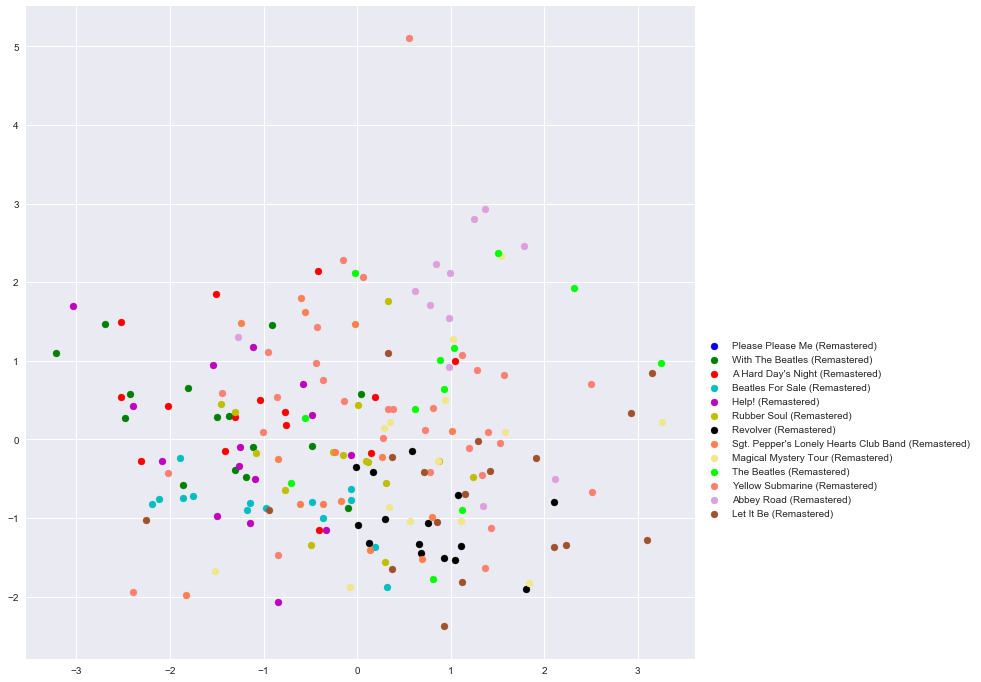

In [71]:
## Plotting results of LDA transformation

for i in range(len(album_list)):
    plt.scatter(transformed_2[y == i][0], transformed_2[y == i][1], label = album_list[i], c = color_list[i])

plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## t-SNE clustering

In [72]:
## Defining 4 components for LDA and applying fit_transform

tsne = TSNE(n_components = 2, perplexity = 80, learning_rate = 850)
transformed_3 = pd.DataFrame(tsne.fit_transform(transformed_2))

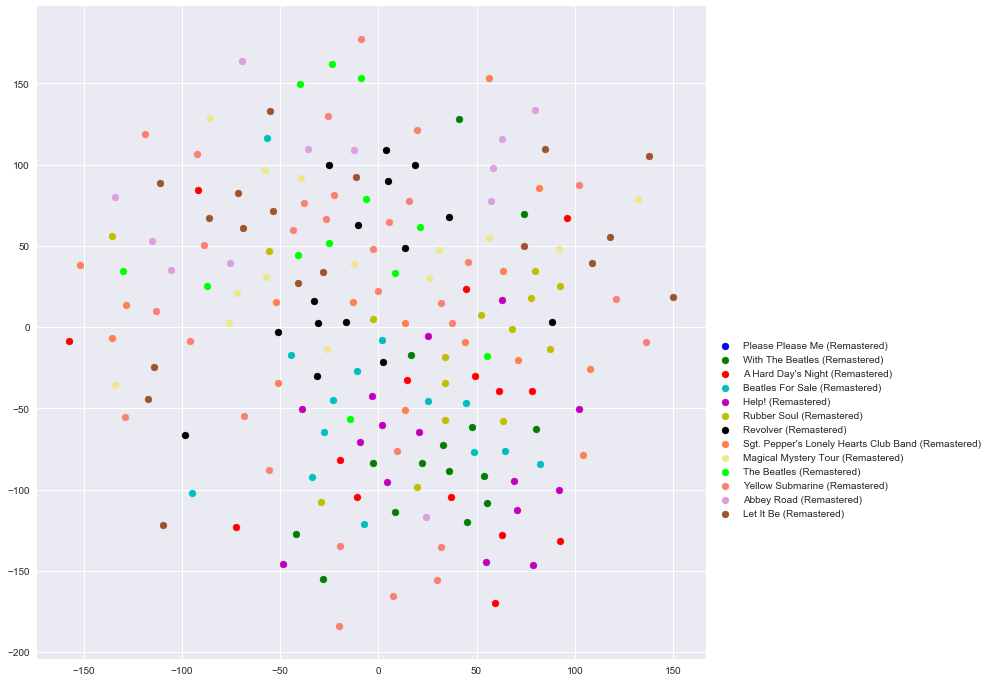

In [73]:
## Plotting results of t-SNE transformation

for i in range(len(album_list)):
    plt.scatter(transformed_3[y == i][0], transformed_3[y == i][1], label = album_list[i], c = color_list[i])

plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

## t-SNE clustering in Bokeh

In [74]:
## Creating new df for interactive Bokeh graphs

tsne_df = pd.concat([reg_features[['album_name', 'song_name', 'album_number']], transformed_3.iloc[:,:2]], axis=1, join_axes=[reg_features.index])

tsne_df.rename(columns = {0 : 'x', 1 : 'y'}, inplace = True)

In [215]:
## Resetting the html output to prevent multiple graphs from showing up

bpl.reset_output()

## Hover tool set to show album number, album name and song name

hover = bmo.HoverTool(
    tooltips = [
        ('Album #: ', '@album_number'),
        ('Album Name: ', '@album_name'),
        ('Song Name: ', '@song_name')])

## Configuring tools that will be used in the plot (plot size is large for viewing on monitor and not laptop)

p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 1600, plot_height = 1200,  toolbar_location = 'above')

## Removing all lines and text, since location on the grid doesn't add any information for analysis

p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.xaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = '0pt'

p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.axis_line_color = None
p.yaxis.major_label_text_font_size = '0pt'

p.grid.visible = False

## Creating color palette/map

palette = d3['Category20'][len(tsne_df['album_name'].unique())]
color_map = bmo.CategoricalColorMapper(factors = tsne_df['album_name'].unique(), palette = palette) 

p.background_fill_color = 'beige'
p.background_fill_alpha = 0.5

## Creating plots and legend information

plot_names = []
legend_list = []

for i in range(len(album_list)):
    plot_names.append("tsne_plot_" + str(i))
     
for j in range(len(plot_names)):
    plot_names[j] = p.circle(x = 'x', y = 'y', source = tsne_df[tsne_df.album_name == album_list[j]], color = palette[j], 
                        size = 6, alpha = 0.75, muted_color = palette[j], muted_alpha = 0.1)
    legend_list.append((album_list[j], [plot_names[j]]))
    
legend = Legend(items = legend_list, location = (0,30))

p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

## Show the Results

output_file("PCA_beatles.html")
bpl.output_notebook()
show(p)

Loading BokehJS ...

## Use Agglomerative Clustering to produce albums

In [150]:

from sklearn.cluster import AgglomerativeClustering

In [192]:
agg_clust = AgglomerativeClustering(n_clusters = len(album_list))

In [159]:
agg_clust_model = agg_clust.fit(transformed_2)

In [168]:
agg_clust_pred = pd.Series(agg_clust_model.fit_predict(transformed_2))

In [208]:
agg_clust_pred = agg_clust_pred.rename('agg_grouped_albums')

In [186]:
testing = pd.concat([reg_features, agg_clust_pred], axis=1)
testing.rename(columns = {0 : 'clustered_album'}, inplace = True)

In [187]:
testing = testing.sort_values(by = 'clustered_album')

In [189]:
testing.clustered_album.value_counts()

3     36
6     27
11    25
1     24
5     19
0     16
2     14
9     12
12    10
4      7
10     6
8      5
7      3
Name: clustered_album, dtype: int64

In [218]:
## Defining 4 components for LDA and applying fit_transform

lda = LinearDiscriminantAnalysis(n_components = 5)
transformed_agg_clust = pd.DataFrame(lda.fit_transform(X_norm, agg_clust_pred))

agg_clust_unique = agg_clust_pred.unique()

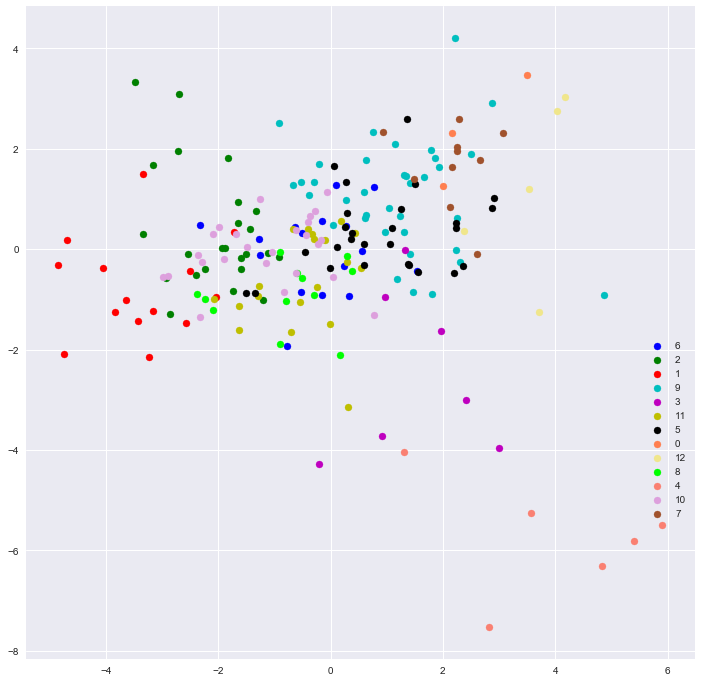

In [179]:
## Plotting results of LDA transformation

for i in range(len(agg_clust_unique)):
    plt.scatter(transformed_agg_clust[agg_clust_pred == i][0], transformed_agg_clust[agg_clust_pred == i][1], label = agg_clust_unique[i], c = color_list[i])

plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

In [212]:
## Creating new df for interactive Bokeh graphs

agg_tsne_df = pd.concat([reg_features[['album_name', 'song_name']], transformed_agg_clust.iloc[:,:2]], axis=1, join_axes=[reg_features.index])
agg_tsne_df.rename(columns = {0 : 'x', 1 : 'y'}, inplace = True)
agg_tsne_df = pd.concat([agg_tsne_df, agg_clust_pred], axis = 1, join_axes=[reg_features.index])

In [221]:
## Resetting the html output to prevent multiple graphs from showing up

bpl.reset_output()

## Hover tool set to show album number, album name and song name

hover = bmo.HoverTool(
    tooltips = [
        ('Album #: ', '@album_number'),
        ('Album Name: ', '@album_name'),
        ('Song Name: ', '@song_name')])

## Configuring tools that will be used in the plot (plot size is large for viewing on monitor and not laptop)

p = figure(tools = [hover, "box_select, box_zoom, lasso_select, reset"], plot_width = 1600, plot_height = 1200,  toolbar_location = 'above')

## Removing all lines and text, since location on the grid doesn't add any information for analysis

p.xaxis.major_tick_line_color = None
p.xaxis.minor_tick_line_color = None
p.xaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = '0pt'

p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.axis_line_color = None
p.yaxis.major_label_text_font_size = '0pt'

p.grid.visible = False

## Creating color palette/map

palette = d3['Category20'][len(agg_tsne_df['album_name'].unique())]
color_map = bmo.CategoricalColorMapper(factors = agg_tsne_df['album_name'].unique(), palette = palette) 

p.background_fill_color = 'beige'
p.background_fill_alpha = 0.5

## Creating plots and legend information

plot_names = []
legend_list = []

for i in range(len(agg_clust_unique)):
    plot_names.append("agg_tsne_plot_" + str(i))
     
for j in range(len(plot_names)):
    plot_names[j] = p.circle(x = 'x', y = 'y', source = agg_tsne_df[agg_tsne_df.album_name == album_list[j]], color = palette[j], 
                        size = 6, alpha = 0.75, muted_color = palette[j], muted_alpha = 0.1)
    legend_list.append((agg_clust_unique[j], [plot_names[j]]))
    
legend = Legend(items = legend_list, location = (0,30))

p.add_layout(legend, 'right')
p.legend.click_policy = 'mute'

## Show the Results

output_file("Agg_TSNE_beatles.html")
bpl.output_notebook()
show(p)

ValueError: expected an element of List(Instance(LegendItem)), got seq with invalid items [(6, [GlyphRenderer(id='d5ee93b1-2d83-4ce4-b561-0d786ecc5c2b', ...)]), (2, [GlyphRenderer(id='17ebcb14-f658-4ef2-bc18-c00e887ad236', ...)]), (1, [GlyphRenderer(id='dba9be8b-2cad-4430-8df1-03aa7e4a6eb1', ...)]), (9, [GlyphRenderer(id='2932e71a-37f6-42d2-9dc7-fa876801bc21', ...)]), (3, [GlyphRenderer(id='27126009-b2ce-4fde-b6ba-9e35dd78132f', ...)]), (11, [GlyphRenderer(id='9fff4502-54e0-412a-8350-217f9bdc4abe', ...)]), (5, [GlyphRenderer(id='f2cad2b6-d7ce-4f15-b417-1155965462f3', ...)]), (0, [GlyphRenderer(id='22e3ddf2-0d93-4b73-ac5c-e8c9ed306af8', ...)]), (12, [GlyphRenderer(id='1f83d213-12bf-481f-9531-9ca16fdb2887', ...)]), (8, [GlyphRenderer(id='c6da5e32-ff84-42e6-a5dd-a44bb6b9a3ad', ...)]), (4, [GlyphRenderer(id='f3d96ee5-9837-439a-b609-4be33d7e7316', ...)]), (10, [GlyphRenderer(id='0256cc1c-5cfa-4995-a52c-948e91759971', ...)]), (7, [GlyphRenderer(id='b84531dc-411c-4e92-bc6a-4e45961d87d6', ...)])]